In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DataMining2025/통합.csv")

In [ ]:
# 설명변수(X), 종속변수(y) 설정
X_cols = ['총_유동인구_수', '총_상주인구_수', '비교통_집객시설_수', '대중교통_수', '아파트_평균_시가', '월_평균_소득_금액']
y_col = '당월_매출_금액'

X = df[X_cols]
y = df[y_col]

In [ ]:
X.describe()

,총_유동인구_수,총_상주인구_수,비교통_집객시설_수,대중교통_수,아파트_평균_시가,월_평균_소득_금액
count,8.476000e+03,8476.000000,8476.000000,8476.000000,8.476000e+03,8.476000e+03
mean,5.607032e+06,22475.386031,95.416706,30.980651,3.554023e+08,3.388948e+06
std,2.953122e+06,9107.209752,59.525808,18.154086,3.214330e+08,9.553182e+05
min,2.382750e+05,117.000000,9.000000,0.000000,8.185851e+07,2.099146e+06
25%,3.527877e+06,16547.000000,59.000000,18.000000,1.760842e+08,2.679845e+06
50%,5.307239e+06,21790.500000,81.000000,28.000000,2.443406e+08,3.113825e+06
75%,7.030210e+06,27637.250000,117.000000,39.000000,3.893996e+08,3.864301e+06
max,2.258545e+07,58081.000000,512.000000,114.000000,2.672554e+09,7.421305e+06


In [ ]:
y.describe()

,당월_매출_금액
count,8.476000e+03
mean,5.735260e+10
std,9.247069e+10
min,2.627894e+07
25%,1.658654e+10
50%,3.212632e+10
75%,5.836106e+10
max,1.025149e+12


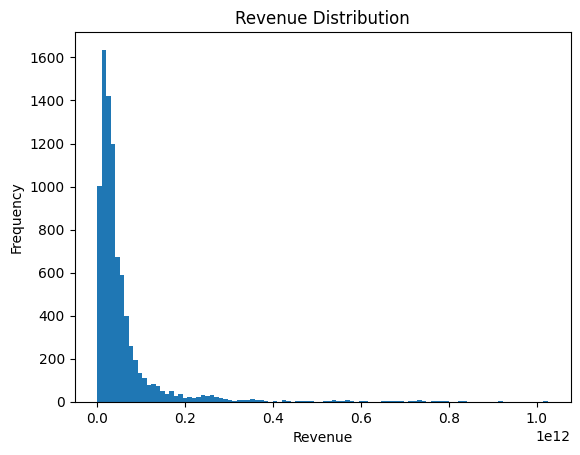

In [ ]:
# 타겟 변수 분포확인
plt.hist(y, bins=100)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

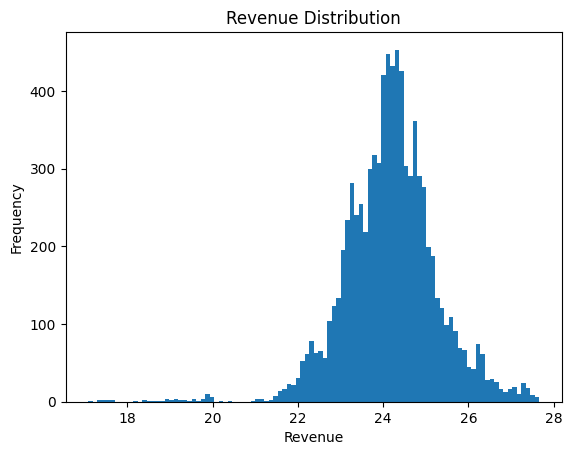

In [ ]:
# 로그 변환 (왜도 보정)
y_log = np.log1p(y)

plt.hist(y_log, bins = 100)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# 이상치 제거 (IQR 기준)
Q1, Q3 = y_log.quantile(0.25), y_log.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

mask = (y_log >= lower) & (y_log <= upper)
X = X[mask].reset_index(drop=True)
y = y_log[mask].reset_index(drop=True)

In [ ]:
# 데이터 분할
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 다중선형회귀
X_train_raw_const = sm.add_constant(X_train_raw)
model_ols = sm.OLS(y_train.reset_index(drop=True), X_train_raw_const.reset_index(drop=True)).fit()

# VIF 계산
vif_raw_df = pd.DataFrame({
    "Feature": X_train_raw_const.columns,
    "VIF": [variance_inflation_factor(X_train_raw_const.values, i) for i in range(X_train_raw_const.shape[1])]
})

print(vif_raw_df)
print(model_ols.summary())


      Feature        VIF
0       const  31.005633
1    총_유동인구_수   1.987858
2    총_상주인구_수   1.656964
3  비교통_집객시설_수   1.724576
4      대중교통_수   1.421658
5   아파트_평균_시가   3.487840
6  월_평균_소득_금액   3.472929
                            OLS Regression Results                            
Dep. Variable:               당월_매출_금액   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1259.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:59:51   Log-Likelihood:                -6443.2
No. Observations:                6604   AIC:                         1.290e+04
Df Residuals:                    6597   BIC:                         1.295e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
          

조건수(Condition Number)가 너무 크다 -> 수치적으로 매우 다른 단위들이 섞여 있어서 수치 불안정성 또는 다중공선성 위험이 생긴다는 뜻

-> 따라서 스케일링 적용

In [ ]:
# 예측 및 평가
X_valid_raw_const = sm.add_constant(X_valid_raw)
y_pred_raw_ols = model_ols.predict(X_valid_raw_const)
mse_ols = mean_squared_error(y_valid, y_pred_raw_ols)
rmse_ols = root_mean_squared_error(y_valid, y_pred_raw_ols)
r2_ols = r2_score(y_valid, y_pred_raw_ols)

print("MSE: ", mse_ols)
print("RMSE: ", rmse_ols)
print("R_squared score", r2_ols)

MSE:  0.3682119555860593
RMSE:  0.606804709594495
R_squared score 0.5389447296555574


In [ ]:
# 스케일링 (StandardScaler)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_cols)
X_valid = pd.DataFrame(scaler.transform(X_valid_raw), columns=X_cols)

In [ ]:
# 다중선형회귀
X_train_const = sm.add_constant(X_train)
model_ols = sm.OLS(y_train.reset_index(drop=True), X_train_const.reset_index(drop=True)).fit()

# VIF 계산
vif_df = pd.DataFrame({
    "Feature": X_train_const.columns,
    "VIF": [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
})

print(vif_df)
print(model_ols.summary())


      Feature       VIF
0       const  1.000000
1    총_유동인구_수  1.987858
2    총_상주인구_수  1.656964
3  비교통_집객시설_수  1.724576
4      대중교통_수  1.421658
5   아파트_평균_시가  3.487840
6  월_평균_소득_금액  3.472929
                            OLS Regression Results                            
Dep. Variable:               당월_매출_금액   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1259.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:59:51   Log-Likelihood:                -6443.2
No. Observations:                6604   AIC:                         1.290e+04
Df Residuals:                    6597   BIC:                         1.295e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 c

In [ ]:
# 예측 및 평가
X_valid_const = sm.add_constant(X_valid)
y_pred_ols = model_ols.predict(X_valid_const)
mse_ols = mean_squared_error(y_valid, y_pred_ols)
rmse_ols = root_mean_squared_error(y_valid, y_pred_ols)
r2_ols = r2_score(y_valid, y_pred_ols)

print("MSE: ", mse_ols)
print("RMSE: ", rmse_ols)
print("R_squared score", r2_ols)

MSE:  0.36821195558609054
RMSE:  0.6068047095945207
R_squared score 0.5389447296555183


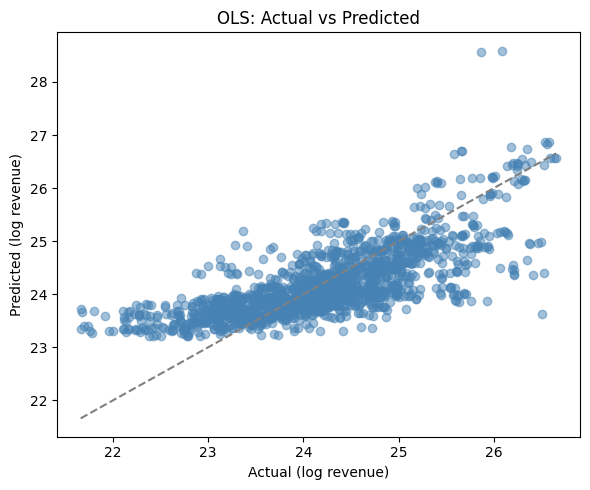

In [ ]:
# 다중선형회귀 시각화
y_pred_ols = model_ols.predict(sm.add_constant(X_valid))

plt.figure(figsize=(6, 5))
plt.scatter(y_valid, y_pred_ols, alpha=0.5, color='steelblue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], '--', color='gray')
plt.xlabel("Actual (log revenue)")
plt.ylabel("Predicted (log revenue)")
plt.title("OLS: Actual vs Predicted")
plt.tight_layout()
plt.show()


In [ ]:
# 1. 나눔고딕 폰트 설치
!apt-get -qq install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

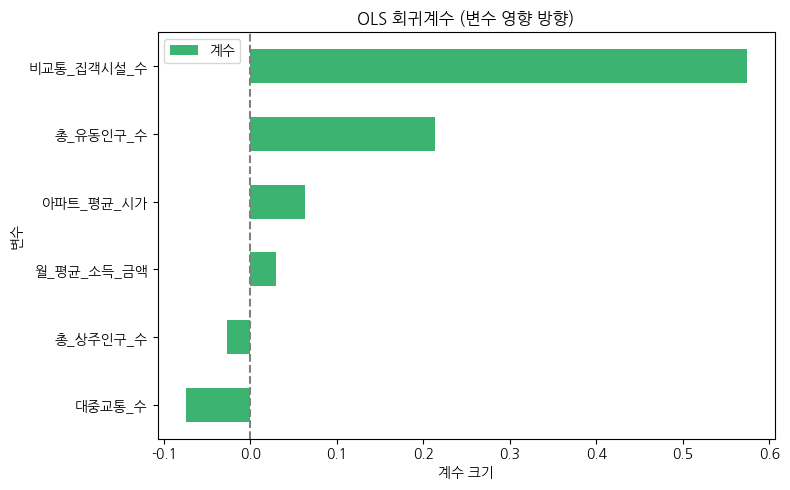

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 계수 시각화
coef_df = pd.DataFrame({
    "변수": model_ols.params.index,
    "계수": model_ols.params.values
}).set_index("변수").drop("const")

coef_df.sort_values(by="계수").plot(kind="barh", color="mediumseagreen", figsize=(8, 5))
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("OLS 회귀계수 (변수 영향 방향)")
plt.xlabel("계수 크기")
plt.tight_layout()
plt.show()


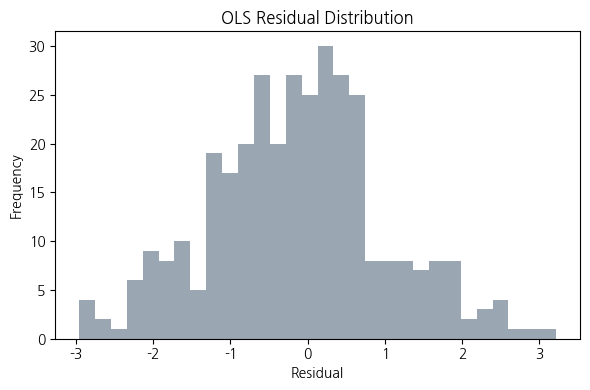

In [ ]:
# 잔차 분석
residuals = y_valid - y_pred_ols

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='slategray', alpha=0.7)
plt.title("OLS Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


중심이 0에 가까움
-> 평균적으로 예측이 과하거나 부족하지 않다는 뜻
-> 모델이 편향 없이 평균적인 예측을 하고 있음

좌우 대칭에 가까움
-> 잔차가 정규분포 형태에 가깝다는 뜻
-> 선형회귀의 잔차 정규성 가정을 대체로 충족함

스케일링 전 후 비교

공통점: R-squared, Adj. R-squared, F-statistic 동일, 비교통_집객시설_수가 가장 중요한 변수로 추출됨

차이점: 계수 해석, 조건수, 다중 공선성 경고

In [ ]:
# 랜덤포레스트 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# 예측 및 평가
y_pred_train = rf.predict(X_train)
y_pred_valid = rf.predict(X_valid)

mse_rf = mean_squared_error(y_valid, y_pred_valid)
rmse_rf = root_mean_squared_error(y_valid, y_pred_valid)
r2_rf = r2_score(y_valid, y_pred_valid)

print("Train R-squared:", round(rf.score(X_train, y_train), 4))
print("Valid R-squared:", round(r2_rf, 4))
print("Valid RMSE:", round(rmse_rf, 4))
print("Valid MSE: ", round(mse_rf, 4))


Train R-squared: 0.9972
Valid R-squared: 0.9836
Valid RMSE: 0.1145
Valid MSE:  0.0131


In [ ]:
# 변수 중요도 탐색
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending = False))

비교통_집객시설_수    0.643659
월_평균_소득_금액    0.083008
총_유동인구_수      0.081346
대중교통_수        0.072526
총_상주인구_수      0.062020
아파트_평균_시가     0.057440
dtype: float64


Text(0, 0.5, 'Predicted_revenue')

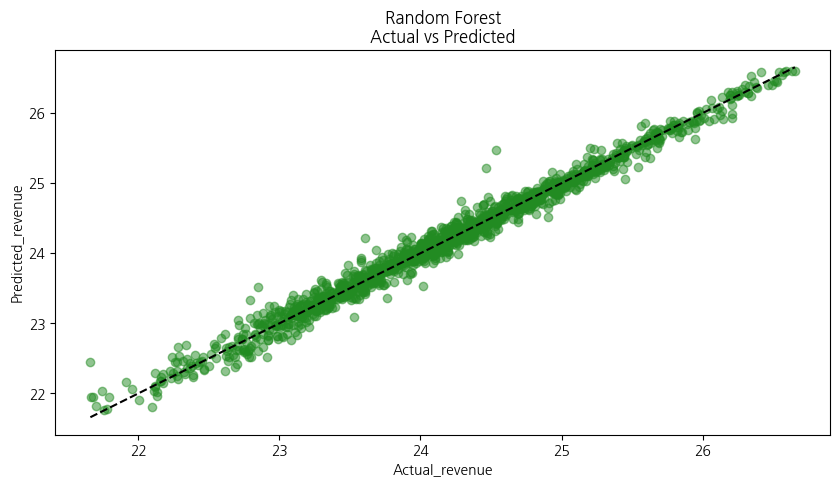

In [ ]:
# 예측값 가져오기
y_pred_rf = rf.predict(X_valid)

plt.figure(figsize=(10, 5))

# 랜덤포레스트
plt.scatter(y_valid, y_pred_rf, alpha=0.5, color='forestgreen')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], '--', color='black')
plt.title("Random Forest\nActual vs Predicted")
plt.xlabel("Actual_revenue")
plt.ylabel("Predicted_revenue")
# x축은 로그변환 된 매출, y축은 로그변환 된 매출 예측값

비교통_집객시설_수가 가장 중요한 변수로 추출됨

특이사항: 행정동 별 월_평균_소득_금액이 두번째로 중요한 변수로 추출됨

In [ ]:
# LightGBM 회귀 모델학습
# LightGBM: 여러 트리를 이어 붙여서 오차를 줄이며 학습하고, 잎부터 뻗어나가서 복잡한 비선형 관계도 잘 잡아낸다.
lgb_model = lgb.LGBMRegressor(random_state=42)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1248
[LightGBM] [Info] Number of data points in the train set: 6604, number of used features: 6
[LightGBM] [Info] Start training from score 24.168831


LGBMRegressor(random_state=42)

In [ ]:
# 2. 예측 수행
y_pred_train = lgb_model.predict(X_train)
y_pred_valid = lgb_model.predict(X_valid)

In [ ]:
# 성능 평가
mse_lgb = mean_squared_error(y_valid, y_pred_valid)
rmse_lgb = root_mean_squared_error(y_valid, y_pred_valid)
r2_lgb = r2_score(y_valid, y_pred_valid)

print("Train R-squared:", round(r2_score(y_train, y_pred_train), 4))
print("Valid R-squared:", round(r2_lgb, 4))
print("Valid MSE:", round(mse_lgb, 4))
print("Valid RMSE:", round(rmse_lgb, 4))


Train R-squared: 0.9697
Valid R-squared: 0.9579
Valid MSE: 0.0336
Valid RMSE: 0.1833


In [ ]:
# 변수 중요도 추출
importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending = False))

월_평균_소득_금액    626
비교통_집객시설_수    538
대중교통_수        530
아파트_평균_시가     511
총_상주인구_수      413
총_유동인구_수      382
dtype: int32


월 평균 소득 금액이 가장 중요한 변수로 추출됨

In [ ]:
# 7. 성능 비교 출력

print("다중선형회귀 MSE:", round(mse_ols, 4)," / RMSE:", round(rmse_ols, 4), " / R²:", round(r2_ols, 4))
print("랜덤포레스트  MSE:", round(mse_rf, 4)," / RMSE:", round(rmse_rf, 4), " / R²:", round(r2_rf, 4))
print("LightGBM     MSE:", round(mse_lgb, 4)," / RMSE:", round(rmse_lgb, 4), " / R²:", round(r2_lgb, 4))


다중선형회귀 MSE: 0.3682  / RMSE: 0.6068  / R²: 0.5389
랜덤포레스트  MSE: 0.0131  / RMSE: 0.1145  / R²: 0.9836
LightGBM     MSE: 0.0336  / RMSE: 0.1833  / R²: 0.9579


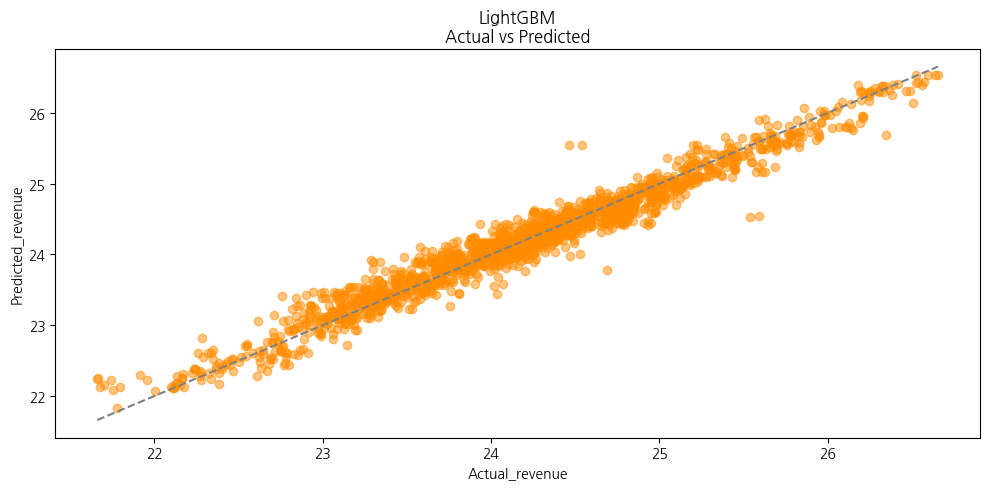

In [ ]:
# LightGBM
# 예측값 가져오기
y_pred_lgb = lgb_model.predict(X_valid)

plt.figure(figsize=(10, 5))
plt.scatter(y_valid, y_pred_lgb, alpha=0.5, color='darkorange')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], '--', color='gray')
plt.title("LightGBM\nActual vs Predicted")
plt.xlabel("Actual_revenue")
plt.ylabel("Predicted_revenue")

plt.tight_layout()
plt.show()
# x축은 로그변환 된 매출, y축은 로그변환 된 매출 예측값
